In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from shapely.geometry import Polygon, box


In [ ]:
ddir = 'G:\Alexis_data\Project\SpatialOmics_cellpose\results'
fullres_chanel_0 = "G:\Alexis_data\Project\SpatialOmics_cellpose\data\output-XETG00245__0034182__1835os__20240613__195055\morphology_focus\morphology_focus_0000.ome.tif"
fullres_chanel_2 = "G:\Alexis_data\Project\SpatialOmics_cellpose\data\output-XETG00245__0034182__1835os__20240613__195055\morphology_focus\morphology_focus_0002.ome.tif"

# Output directory
odir = f'{ddir}cellpose/'
gjurl = f'{odir}a.geojson'

# Levels: pixelsize in µm https://kb.10xgenomics.com/hc/en-us/articles/11636252598925
scalefactors = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2,
}


In [2]:
# Example usage
ROI_filepath = "G:/Alexis_data/Project/SpatialOmics_cellpose/data/output-XETG00245__0034182__1835od__20240613__195055/1835od_corneasection.csv"

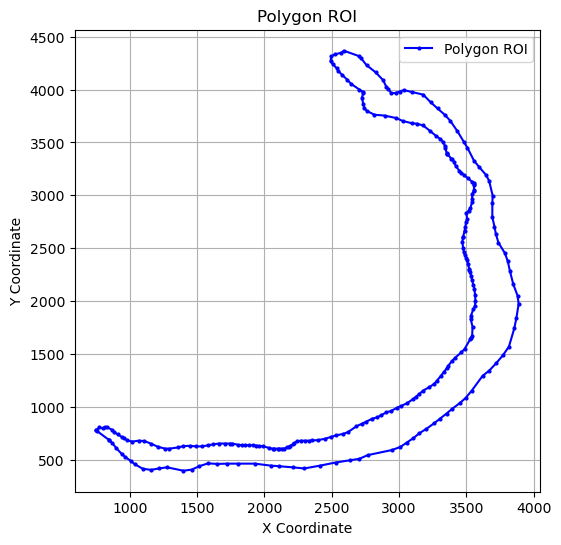

In [9]:
# Read the ROI coordinates from the CSV file
polygon_coords = pd.read_csv(ROI_filepath)

# Extract the X and Y coordinates
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']


# Create a plot
plt.figure(figsize=(6, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Polygon ROI', markersize=2)

# Close the polygon by connecting the last point to the first
plt.plot([x_coords.iloc[0], x_coords.iloc[-1]], [y_coords.iloc[0], y_coords.iloc[-1]], 'b-')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title("Polygon ROI")
plt.legend()
plt.grid(True)

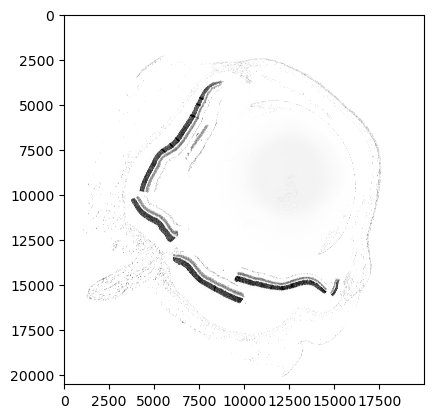

In [7]:
level = 0
pixelsize = scalefactors[level]
image_chanel_0 = tifffile.imread(fullres_chanel_0, is_ome=False, level=level)
plt.imshow(image_chanel_0, cmap='binary')
plt.axis('scaled')
plt.show()

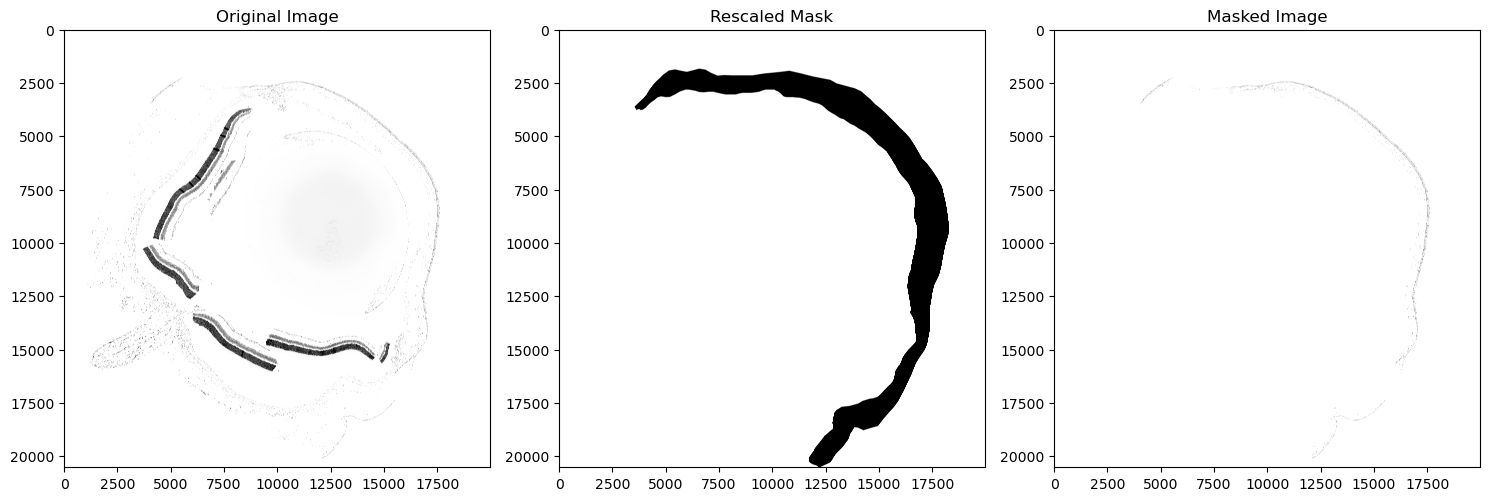

In [20]:
import cv2
import numpy as np

level = 0
pixelsize = scalefactors[level]

# 1. Rescale the coordinates
scaling_factor = pixelsize
x_coords_rescaled = x_coords / scaling_factor
y_coords_rescaled = y_coords / scaling_factor

# 2. Convert rescaled coordinates to points format for fillPoly
points_rescaled = np.column_stack((x_coords_rescaled, y_coords_rescaled)).astype(np.int32)
points_rescaled = points_rescaled.reshape((-1, 1, 2))

# 3. Create mask matching image shape
mask = np.zeros(image_chanel_0.shape, dtype=np.uint8)

# 4. Fill the polygon in white (255)
cv2.fillPoly(mask, [points_rescaled], color=255)

# 5. Apply mask to original image
mask_bool = mask > 0
masked_image_0 = np.zeros_like(image_chanel_0)
masked_image_0[mask_bool] = image_chanel_0[mask_bool]

# 6. Visualize to check the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image_chanel_0, cmap='binary')
plt.title('Original Image')
plt.axis('scaled')

plt.subplot(132)
plt.imshow(mask, cmap='binary')
plt.title('Rescaled Mask')
plt.axis('scaled')

plt.subplot(133)
plt.imshow(masked_image_0, cmap='binary')
plt.title('Masked Image')
plt.axis('scaled')

plt.tight_layout()
plt.show()

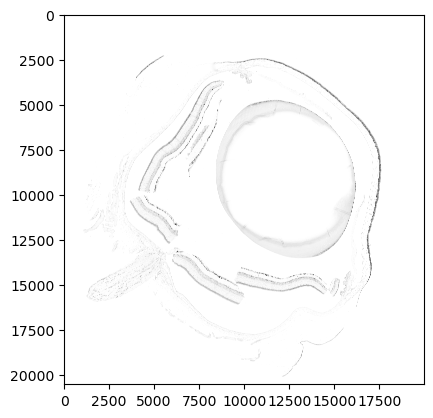

In [8]:
image_chanel_2 = tifffile.imread(fullres_chanel_2, is_ome=False, level=level)
plt.imshow(image_chanel_2, cmap='binary')
plt.axis('scaled')
plt.show()

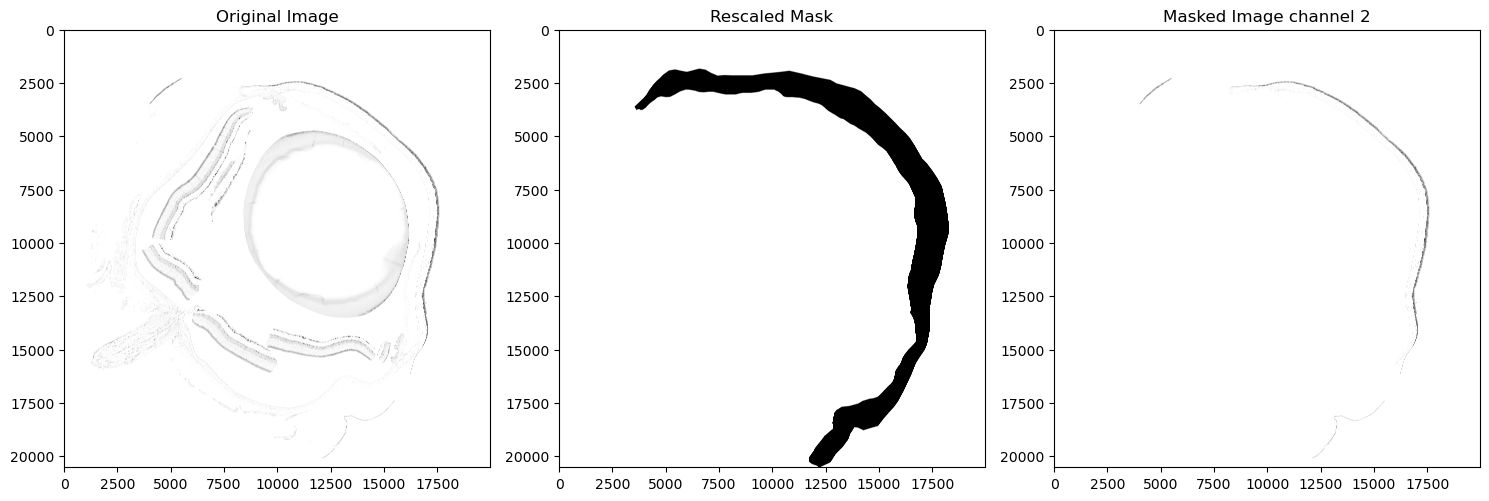

In [14]:
import cv2
import numpy as np

level = 0
pixelsize = scalefactors[level]

# 1. Rescale the coordinates
scaling_factor = pixelsize
x_coords_rescaled = x_coords / scaling_factor
y_coords_rescaled = y_coords / scaling_factor

# 2. Convert rescaled coordinates to points format for fillPoly
points_rescaled = np.column_stack((x_coords_rescaled, y_coords_rescaled)).astype(np.int32)
points_rescaled = points_rescaled.reshape((-1, 1, 2))

# 3. Create mask matching image shape
mask = np.zeros(image_chanel_0.shape, dtype=np.uint8)

# 4. Fill the polygon in white (255)
cv2.fillPoly(mask, [points_rescaled], color=255)

# 5. Apply mask to original image
mask_bool = mask > 0
masked_image_2 = np.zeros_like(image_chanel_2)
masked_image_2[mask_bool] = image_chanel_2[mask_bool]

# 6. Visualize to check the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image_chanel_2, cmap='binary')
plt.title('Original Image')
plt.axis('scaled')

plt.subplot(132)
plt.imshow(mask, cmap='binary')
plt.title('Rescaled Mask')
plt.axis('scaled')

plt.subplot(133)
plt.imshow(masked_image_2, cmap='binary')
plt.title('Masked Image channel 2')
plt.axis('scaled')

plt.tight_layout()
plt.show()

In [15]:

def crop_polygon_to_overlapping_squares(polygon, square_size, overlap_size=40):
    """
    Crops a polygon into overlapping square regions of a given size.

    Args:
        polygon (Polygon): The input polygon to crop.
        square_size (float): The base size of each square region (side length).
        overlap_size (float): The amount of overlap in um (default: 20).

    Returns:
        List[Polygon]: List of overlapping square polygons that fully contain the polygon.
    """
    # Get bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Generate grid of overlapping squares
    squares = []
    for x in range(int(minx), int(maxx), square_size):
        for y in range(int(miny), int(maxy), square_size):
            # Create expanded square with overlap
            # First vertex (x, y) remains the same
            # Other vertices are expanded by overlap_size
            square = box(
                x,                          # minx (unchanged)
                y,                          # miny (unchanged)
                x + square_size + overlap_size,  # maxx (expanded)
                y + square_size + overlap_size   # maxy (expanded)
            )
            # Check if the square intersects the polygon
            if polygon.intersects(square):
                squares.append(square)
    
    return squares

In [16]:
# Combine X and Y into coordinate pairs
rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))

# Create a Polygon object
rescaled_polygon_roi = Polygon(rescaled_polygon_roi)
print(rescaled_polygon_roi)

POLYGON ((3971.011764705883 3233.741176470588, 4097.035294117647 3082.494117647059, 4235.670588235294 2855.623529411765, 4412.141176470588 2616.188235294118, 4550.7764705882355 2464.9411764705883, 4727.2 2301.0823529411764, 4891.058823529412 2137.223529411765, 5155.717647058823 1948.1882352941177, 5445.6 1897.7882352941176, 5722.870588235294 1960.8000000000002, 6000.1882352941175 2011.2, 6579.952941176471 1859.9529411764706, 6869.835294117647 1910.3529411764705, 7134.494117647058 2061.6, 7436.988235294118 2187.670588235294, 7764.658823529412 2162.4470588235295, 8092.376470588236 2175.0588235294117, 8470.494117647058 2175.0588235294117, 9075.435294117648 2175.0588235294117, 9630.023529411765 2086.823529411765, 9907.29411764706 2061.6, 10398.823529411766 2011.2, 10802.164705882353 1960.8000000000002, 11356.705882352942 2086.823529411765, 11898.682352941176 2225.458823529412, 12415.388235294118 2326.305882352941, 12730.494117647058 2389.3176470588237, 13020.376470588235 2553.176470588235,

square: POLYGON ((5439 1859, 5439 3781, 3517 3781, 3517 1859, 5439 1859))
 x: array('d', [5439.0, 5439.0, 3517.0, 3517.0, 5439.0]) 
 y: array('d', [1859.0, 3781.0, 3781.0, 1859.0, 1859.0])
square: POLYGON ((5439 3741, 5439 5663, 3517 5663, 3517 3741, 5439 3741))
 x: array('d', [5439.0, 5439.0, 3517.0, 3517.0, 5439.0]) 
 y: array('d', [3741.0, 5663.0, 5663.0, 3741.0, 3741.0])
square: POLYGON ((7321 1859, 7321 3781, 5399 3781, 5399 1859, 7321 1859))
 x: array('d', [7321.0, 7321.0, 5399.0, 5399.0, 7321.0]) 
 y: array('d', [1859.0, 3781.0, 3781.0, 1859.0, 1859.0])
square: POLYGON ((9203 1859, 9203 3781, 7281 3781, 7281 1859, 9203 1859))
 x: array('d', [9203.0, 9203.0, 7281.0, 7281.0, 9203.0]) 
 y: array('d', [1859.0, 3781.0, 3781.0, 1859.0, 1859.0])
square: POLYGON ((11085 1859, 11085 3781, 9163 3781, 9163 1859, 11085 1859))
 x: array('d', [11085.0, 11085.0, 9163.0, 9163.0, 11085.0]) 
 y: array('d', [1859.0, 3781.0, 3781.0, 1859.0, 1859.0])
square: POLYGON ((12967 1859, 12967 3781, 11045 3

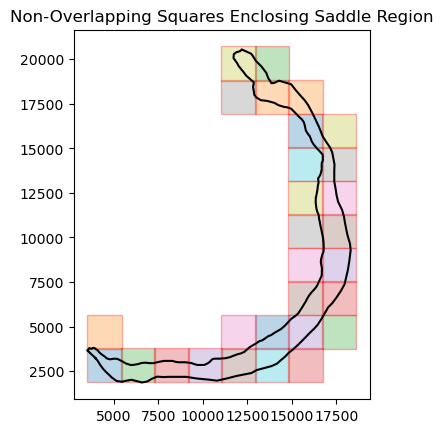

In [17]:
# Define square size
square_size = int(400/0.2125) # Adjust as necessary 


# Generate non-overlapping square regions
overlapping_squares = crop_polygon_to_overlapping_squares(rescaled_polygon_roi, square_size)

# Visualization
fig, ax = plt.subplots()
# Plot the original polygon
x, y = rescaled_polygon_roi.exterior.xy
ax.plot(x, y, 'k-', label="Saddle-shaped Polygon")  # Black for polygon

# Plot the square regions
for square in overlapping_squares:
    print("square:", square)
    x, y = square.exterior.xy
    print(" x:", x,"\n", "y:", y)
    ax.fill(x, y, edgecolor='red', alpha=0.3, label="Red Square")

# Add labels and legend
ax.set_title(f"Non-Overlapping Squares Enclosing Saddle Region")
ax.set_aspect('equal', 'box')
# ax.legend(loc="upper left")
plt.show()

In [18]:
overlapping_squares

[<POLYGON ((5439 1859, 5439 3781, 3517 3781, 3517 1859, 5439 1859))>,
 <POLYGON ((5439 3741, 5439 5663, 3517 5663, 3517 3741, 5439 3741))>,
 <POLYGON ((7321 1859, 7321 3781, 5399 3781, 5399 1859, 7321 1859))>,
 <POLYGON ((9203 1859, 9203 3781, 7281 3781, 7281 1859, 9203 1859))>,
 <POLYGON ((11085 1859, 11085 3781, 9163 3781, 9163 1859, 11085 1859))>,
 <POLYGON ((12967 1859, 12967 3781, 11045 3781, 11045 1859, 12967 1859))>,
 <POLYGON ((12967 3741, 12967 5663, 11045 5663, 11045 3741, 12967 3741))>,
 <POLYGON ((12967 16915, 12967 18837, 11045 18837, 11045 16915, 12967 16915))>,
 <POLYGON ((12967 18797, 12967 20719, 11045 20719, 11045 18797, 12967 18797))>,
 <POLYGON ((14849 1859, 14849 3781, 12927 3781, 12927 1859, 14849 1859))>,
 <POLYGON ((14849 3741, 14849 5663, 12927 5663, 12927 3741, 14849 3741))>,
 <POLYGON ((14849 16915, 14849 18837, 12927 18837, 12927 16915, 14849 16915))>,
 <POLYGON ((14849 18797, 14849 20719, 12927 20719, 12927 18797, 14849 18797))>,
 <POLYGON ((16731 1859, 167

In [23]:
# Define a function to crop the image based on a shapely Polygon
def crop_region(image, poly):
    """
    Crops the rectangular bounding box of a polygon from an image.

    Parameters:
        image (ndarray): The original image to crop.
        poly (Polygon): A shapely Polygon object defining the region.

    Returns:
        ndarray: The cropped image region.
    """
    # Get the bounding box of the polygon
    min_x, min_y, max_x, max_y = map(int, poly.bounds)
    
    # Crop the image using the bounding box
    cropped_image = image[min_y:max_y, min_x:max_x]
    
    return cropped_image


# Process and plot the square regions
for i, square in enumerate(overlapping_squares):
    print(f"Processing square {i + 1}:", square)
    
    # ch 0 Crop the region 
    cropped_image_sub = crop_region(masked_image_0, square)

    # ch2 Crop the region
    cropped_image_sub2 = crop_region(masked_image_2, square)

    cropped_image_sub_combined = np.stack((cropped_image_sub, cropped_image_sub2), axis=0)


    # Save the cropped image
    save_path = f"G:/Alexis_data/Project/SpatialOmics_cellpose/results/cropped_image/cropped_square_com_{i + 1}.tif"
    tifffile.imwrite(save_path, cropped_image_sub_combined)
    print(f"Cropped image saved to {save_path}")
    

Processing square 1: POLYGON ((5439 1859, 5439 3781, 3517 3781, 3517 1859, 5439 1859))
Cropped image saved to G:/Alexis_data/Project/SpatialOmics_cellpose/results/cropped_image/cropped_square_com_1.tif
Processing square 2: POLYGON ((5439 3741, 5439 5663, 3517 5663, 3517 3741, 5439 3741))
Cropped image saved to G:/Alexis_data/Project/SpatialOmics_cellpose/results/cropped_image/cropped_square_com_2.tif
Processing square 3: POLYGON ((7321 1859, 7321 3781, 5399 3781, 5399 1859, 7321 1859))
Cropped image saved to G:/Alexis_data/Project/SpatialOmics_cellpose/results/cropped_image/cropped_square_com_3.tif
Processing square 4: POLYGON ((9203 1859, 9203 3781, 7281 3781, 7281 1859, 9203 1859))
Cropped image saved to G:/Alexis_data/Project/SpatialOmics_cellpose/results/cropped_image/cropped_square_com_4.tif
Processing square 5: POLYGON ((11085 1859, 11085 3781, 9163 3781, 9163 1859, 11085 1859))
Cropped image saved to G:/Alexis_data/Project/SpatialOmics_cellpose/results/cropped_image/cropped_squa